In [1]:
import chess
import chess.engine
import chess.svg
import chess.pgn
from IPython.display import SVG, display
import time
from engine import MyEngine

import data.download

%load_ext autoreload
%autoreload 2

We will now download move tables to ensure optimal play during the opening and the endamge (up to 5 remaining pieces)

Make sure you are OK with the data before downloading/using it as these files are downloaded from 3rd partys and I don't claim responsibility for the integrity of them

In [ ]:
data.download.download_syzygy_from_url()
data.download.dowload_polyglot_from_url()
data.download.download_stockfish_from_url()

We will create 2 engines one for each player (one is our engine the other is the current version of the stock fish engine)

In [65]:
engine = chess.engine.SimpleEngine.popen_uci("./data/stockfish/stockfish_15_linux_x64_ssse/stockfish_15_x64_ssse")
myengine = MyEngine()

In [66]:

board = chess.Board()
board_list = [(board.copy(), chess.Move.null())]

while not board.is_game_over():
    if board.turn == chess.WHITE:
        move = myengine.play(board, 2)
    else:
        move = engine.play(board, limit=chess.engine.Limit(time=0.1)).move
        # move = myengine.play(board, 2)

    board.push(move)
    board_list.append((board.copy(), move))


In [63]:
import data.database
import data.dataset
import numpy as np

myengine = MyEngine()

evalutations = np.zeros((2, len(board_list)))

for i , (board, _) in enumerate(board_list):
    score = engine.analyse(board, limit=chess.engine.Limit(time=2.0))["score"].white().score(mate_score = 10000)
    evalutations[0, i] = data.database.normalize(score)
    evalutations[1, i] = myengine.model.forward(data.dataset.encode_board(board)[None, :])
    
engine.quit()

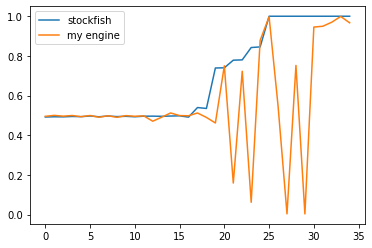

In [64]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import tempfile

move_num = widgets.IntSlider(description='move_num', max=len(board_list)-1)


def display_board(move_num):
    board, move = board_list[move_num]
    display(SVG(chess.svg.board(board, size = 400, lastmove=move)), clear=False)


def engine_score(move_num):
    print(f"stockfish: {evalutations[0, move_num]}")
    print(f"my engine: {evalutations[1, move_num]}")

    
board_svg = widgets.interactive_output(display_board, {'move_num': move_num})
score = widgets.interactive_output(engine_score, {'move_num': move_num})


plt.plot(evalutations[0], label="stockfish")
plt.plot(evalutations[1], label="my engine")
plt.legend()


path = tempfile.tempdir + "/temporaryfile.jpg"
plt.savefig(path)
img = widgets.Image.from_file(path)

widgets.VBox([widgets.VBox([move_num, score]), board_svg])